In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

# Part A

### Reading Data From Iris.csv

In [3]:
data = pd.read_csv('iris.csv')
x = data['petal_length']
y = data['petal_width']

### Scatter Plot of X and Y

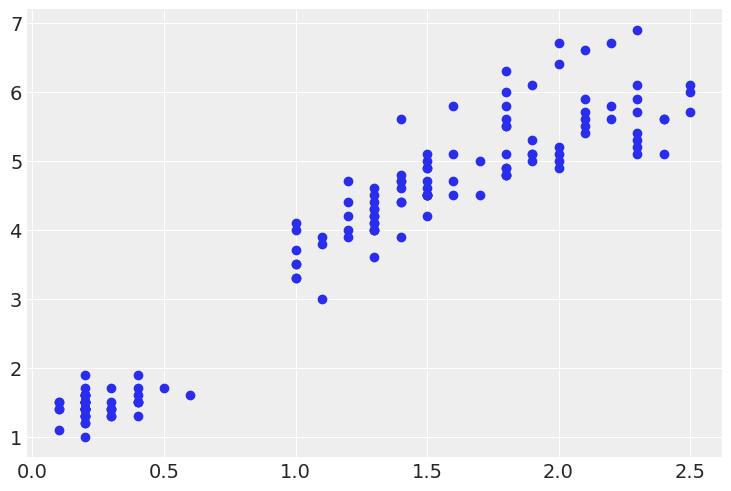

In [4]:
plt.scatter(y,x)

# Non-Robust Linear Regression Model

In [5]:
with pm.Model() as iris_petal:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    y_pred = pm.Normal('y_pred', mu=α+β*x, sd=ϵ, observed=y)
    idata_g = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.


# Robust Linear Regression Model

In [6]:
with pm.Model() as iris_petal_t:
    α = pm.Normal('α', mu=y.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/3)
    ν = pm.Deterministic('ν', ν_ + 1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x, sd=ϵ, nu=ν, observed=y)
    idata_t = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.


# Posterior Plots

C:\Users\MSA\AppData\Local\Temp\ipykernel_13736\2096557670.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.plot(x, posterior_g['α'][draws].values + posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.5)


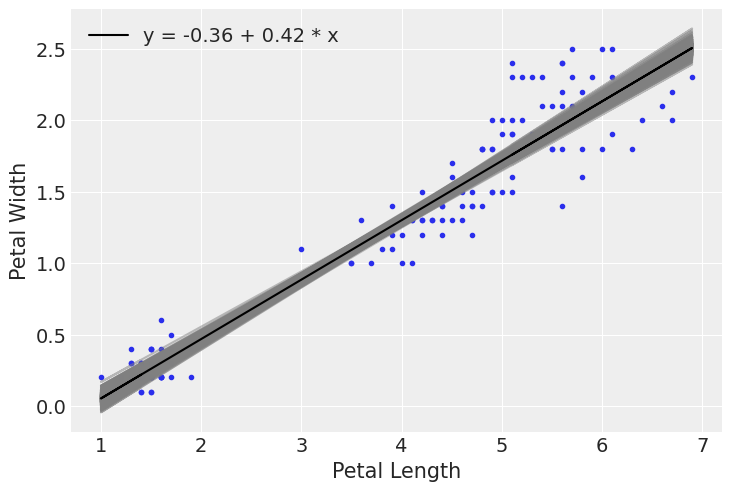

In [7]:
plt.plot(x, y, 'C0.')

posterior_g = idata_g.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior_g['α'].mean().item()
beta_m = posterior_g['β'].mean().item()

draws = range(0, posterior_g.samples.size, 10)
plt.plot(x, posterior_g['α'][draws].values + posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend()

C:\Users\MSA\AppData\Local\Temp\ipykernel_13736\10703852.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.plot(x, posterior_t['α'][draws].values + posterior_t['β'][draws].values * x[:,None], c='gray', alpha=0.5)


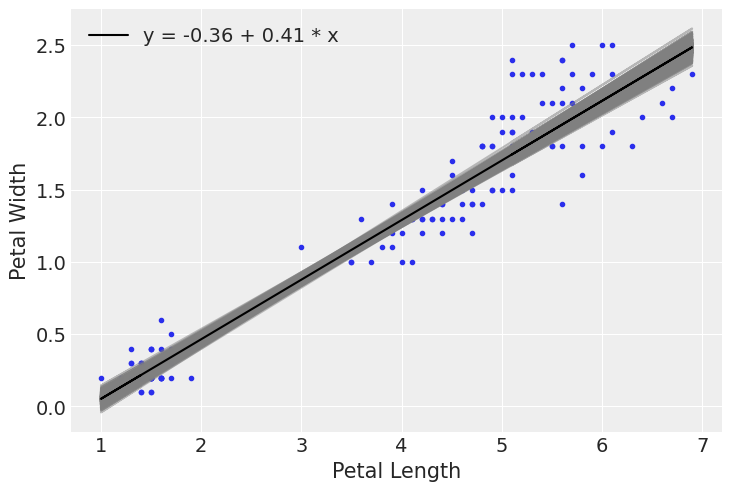

In [8]:
plt.plot(x, y, 'C0.')

posterior_t = idata_t.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior_t['α'].mean().item()
beta_m = posterior_t['β'].mean().item()

draws = range(0, posterior_t.samples.size, 10)
plt.plot(x, posterior_t['α'][draws].values + posterior_t['β'][draws].values * x[:,None], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend()

# Comparison of Robust and Non-Robust Model

### Summary Of Non Robust Model

In [9]:
az.summary(idata_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.363,0.040,-0.438,-0.289,0.001,0.0,3783.0,3920.0,1.0
β,0.416,0.010,0.398,0.433,0.000,0.0,3735.0,3703.0,1.0
ϵ,0.208,0.012,0.185,0.231,0.000,0.0,3832.0,2818.0,1.0


### Summary Of Robust Model

In [10]:
az.summary(idata_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.359,0.037,-0.426,-0.288,0.001,0.000,3236.0,3073.0,1.0
β,0.412,0.010,0.393,0.430,0.000,0.000,3216.0,3258.0,1.0
ϵ,0.173,0.016,0.144,0.205,0.000,0.000,4740.0,4532.0,1.0
ν_,5.527,2.932,1.403,10.908,0.041,0.029,4873.0,4791.0,1.0
ν,6.527,2.932,2.403,11.908,0.041,0.029,4873.0,4791.0,1.0


### Graphical Comparison Models

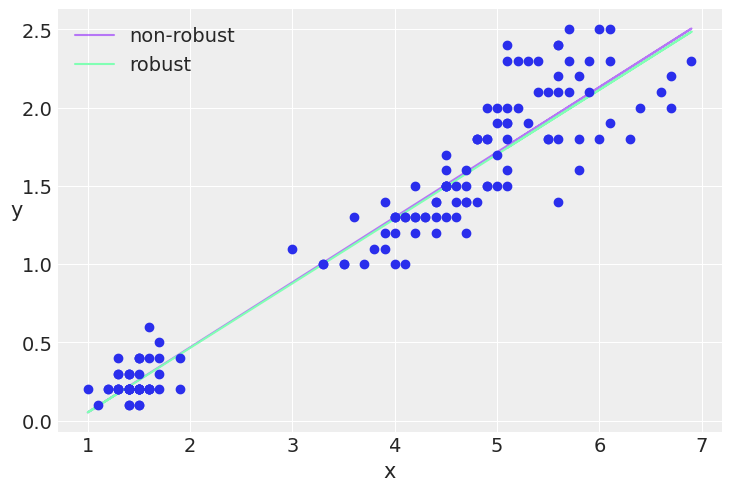

In [11]:
colors = matplotlib.cm.rainbow(np.linspace(0, 1, 3))

alpha_c = idata_g.posterior['α'].mean().item()
beta_c = idata_g.posterior['β'].mean().item()

alpha_m = idata_t.posterior['α'].mean().item()
beta_m = idata_t.posterior['β'].mean().item()

plt.plot(x, alpha_c + beta_c * x, c=colors[0], label='non-robust', alpha=0.5)
plt.plot(x, alpha_m + beta_m * x, c=colors[1], label='robust')
plt.plot(x,y , 'C0o')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)


.
.
### Summary
.
.

As the graphical analysis shows that both models have almost the same slope with a minor difference that is negligible. The difference between slope and y intercept is very small.


.
.
# Part B
.
.
.
# 50% and 94% HDI Plots for Robust and Non Robust Model
.
.



C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


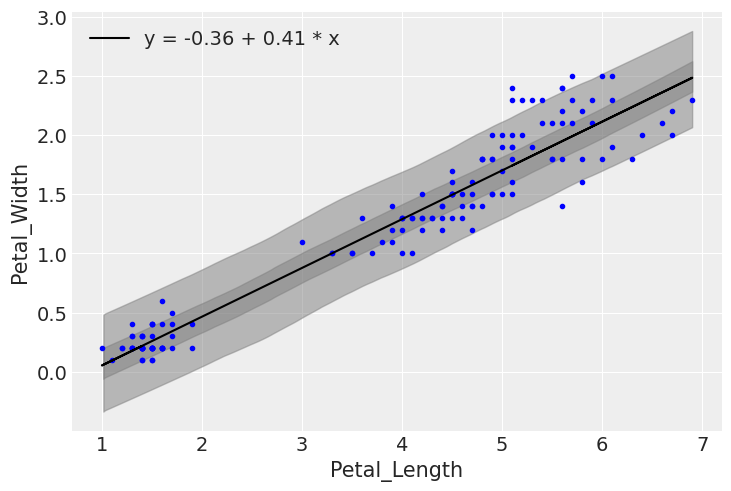

In [12]:
#
#   Robust Model
#
Predictive_Posterior_Robust = pm.sample_posterior_predictive(idata_t, samples=2000, model=iris_petal_t)

alpha_t = idata_t.posterior['α'].mean().item()
beta_t = idata_t.posterior['β'].mean().item()

plt.plot(x, y, 'b.')
plt.plot(x, alpha_t + beta_t * x, c='k', label=f'y = {alpha_t:.2f} + {beta_t:.2f} * x')
az.plot_hdi(x, Predictive_Posterior_Robust['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x, Predictive_Posterior_Robust['y_pred'], color='gray')


plt.xlabel('Petal_Length')
plt.ylabel('Petal_Width')
plt.legend()

C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


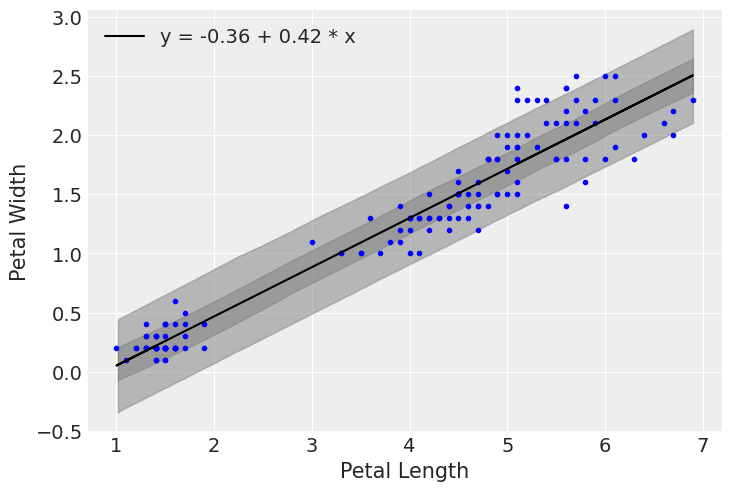

In [13]:
#
#   Non-Robust Model
#
Predictive_Posterior = pm.sample_posterior_predictive(idata_g, samples=2000, model=iris_petal)

alpha = idata_g.posterior['α'].mean().item()
beta = idata_g.posterior['β'].mean().item()

plt.plot(x, y, 'b.')
plt.plot(x, alpha + beta * x, c='k', label=f'y = {alpha:.2f} + {beta:.2f} * x')
az.plot_hdi(x, Predictive_Posterior['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x, Predictive_Posterior['y_pred'], color='gray')

plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc=2)

# Analyzing and Removing Corelation Between Data
.
.

Following Plot Shows that there is high auto corelation between data values. To remove the corelation, we can substract the mean from the values to center them

.
.

C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot: xlabel='α', ylabel='β'>

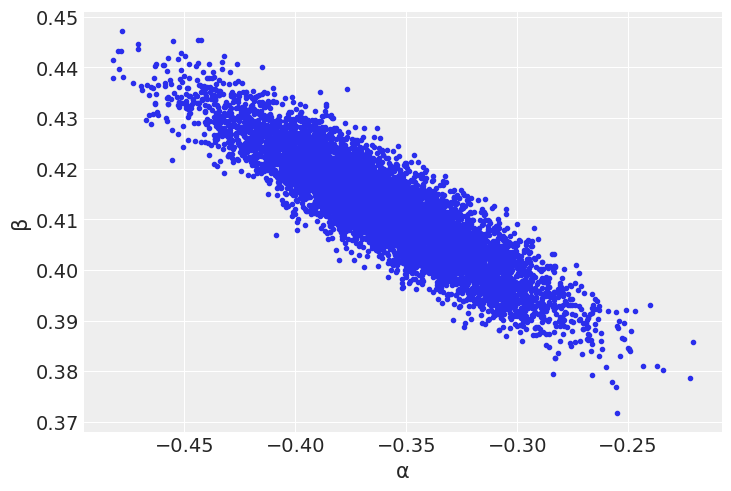

In [14]:
az.plot_pair(idata_t, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})

## Remove Auto Corelation

1. Centering the x variable is one quick and easy technique to get rid of data correlation. This can be done by substracting the mean of the x variable from each data point for x.
2. By standardizing the data, we can even go further. To achieve this, first centre the data and divide each number by the standard deviation.

In [15]:
#xprime = (x - x.mean())/x.std()
#yprime = (y-y.mean())/y.std()
xprime = x - x.mean()
yprime = y

.
.

# Re-Creating Model

.
.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot: xlabel='α', ylabel='β'>

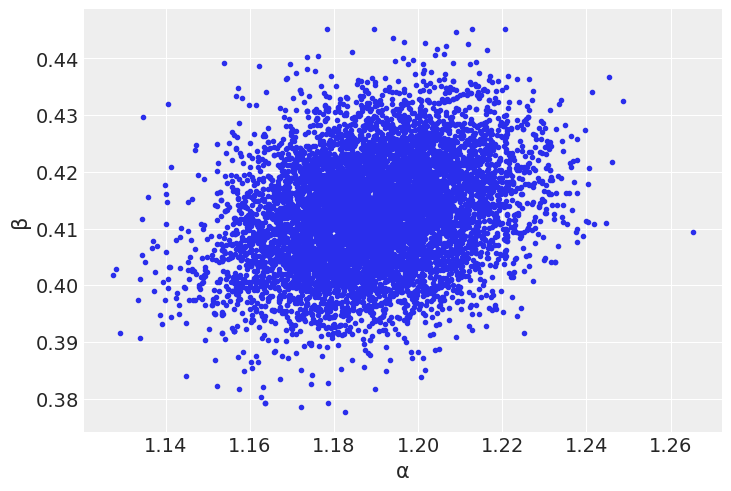

In [16]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν = pm.Exponential('ν', 1/3)

    y_pred = pm.StudentT('y_pred', mu=α + β * xprime, sd=ϵ, nu=ν, observed=yprime)
    idata_c = pm.sample(2000, return_inferencedata=True)
    
az.plot_pair(idata_c, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})


In [17]:
az.summary(idata_c)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.189,0.017,1.157,1.221,0.000,0.000,5121.0,5706.0,1.0
β,0.413,0.010,0.394,0.430,0.000,0.000,5868.0,5149.0,1.0
ϵ,0.174,0.016,0.143,0.202,0.000,0.000,4808.0,4346.0,1.0
ν,6.515,2.858,2.602,11.803,0.041,0.029,4958.0,5377.0,1.0


C:\Users\MSA\AppData\Local\Temp\ipykernel_13736\3736592683.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.plot(xprime, posterior_c['α'][draws].values + posterior_c['β'][draws].values * xprime[:,None], c='gray', alpha=0.5)


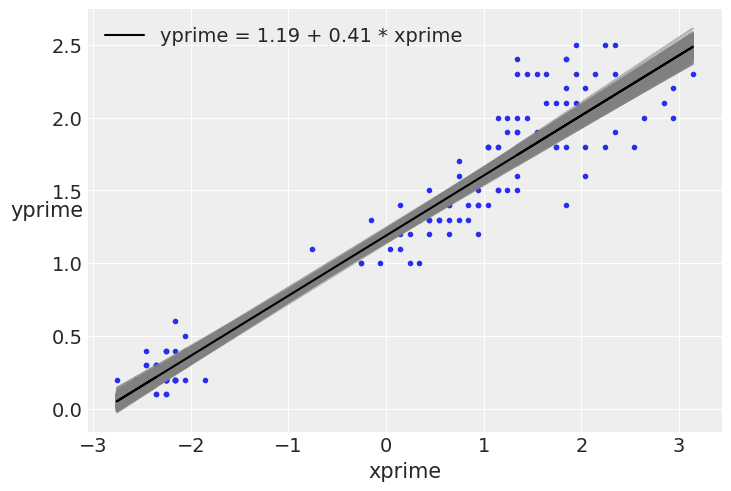

In [18]:
plt.plot(xprime, yprime, 'C0.')

posterior_c = idata_c.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior_c['α'].mean().item()
beta_m = posterior_c['β'].mean().item()

draws = range(0, posterior_c.samples.size, 10)
plt.plot(xprime, posterior_c['α'][draws].values + posterior_c['β'][draws].values * xprime[:,None], c='gray', alpha=0.5)

plt.plot(xprime, alpha_m + beta_m * xprime, c='k',
         label=f'yprime = {alpha_m:.2f} + {beta_m:.2f} * xprime')

plt.xlabel('xprime')
plt.ylabel('yprime', rotation=0)
plt.legend()

C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


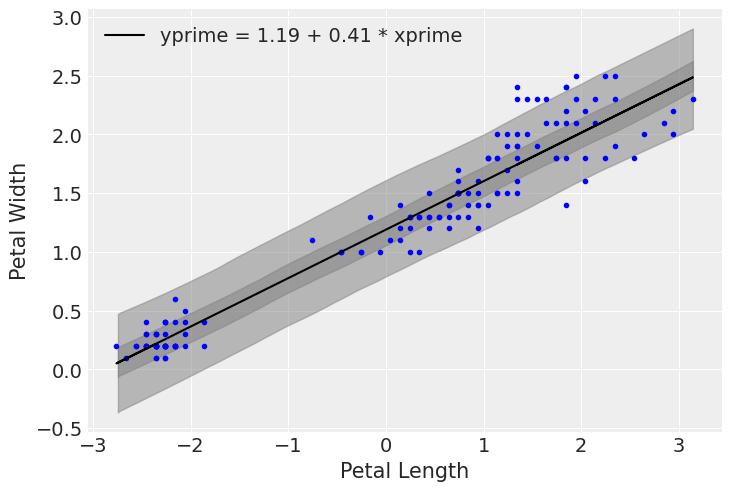

In [19]:
Predictive_Posterior_standard = pm.sample_posterior_predictive(idata_c, samples=2000, model=model_t)

alpha = idata_c.posterior['α'].mean().item()
beta = idata_c.posterior['β'].mean().item()

plt.plot(xprime, yprime, 'b.')
plt.plot(xprime, alpha + beta * xprime, c='k', label=f'yprime = {alpha:.2f} + {beta:.2f} * xprime')
az.plot_hdi(xprime, Predictive_Posterior_standard['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(xprime, Predictive_Posterior_standard['y_pred'], color='gray')

plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc=2)